"**This set of codes looks at developing a recommender algorithm based on content based filtering. We evaluate the similarity of items by calculating their cosine similarity score from the latent features of the anime images obtained via transfer learning using ResNet50.**

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import timeit

## 1. Image Preprocessing

In [2]:
images_dir = r'processed_data/images/'

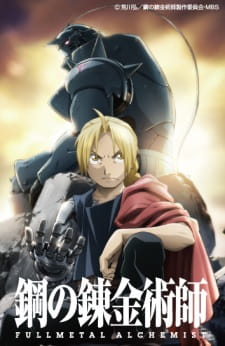

In [3]:
# examine a sample image
img = Image.open(images_dir + 'index_0.jpg')
img

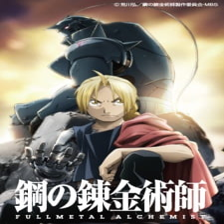

In [4]:
# examine the effects of resizing the image sample 
squashed_image = img.resize([224,224])
squashed_image

**Apply resizing on all images**

In [5]:
# Create new sub directory for the centered images
images_squashed_dir = r'processed_data/images_squashed/'

if not os.path.exists(images_squashed_dir):
    os.makedirs(images_squashed_dir)

In [6]:
# Get file names from original images directory
file_names = os.listdir(images_dir)

# Get all the images, resize and save in new directory
for i in file_names:
    img = Image.open(images_dir + i)
    try:
        # squashed img
        squashed_img = img.resize([224,224])
        # save squashed_img
        squashed_img.save(images_squashed_dir + i)
    except Exception:
        continue

## 2. Using transfer learning from Resnet

Reference: https://stackoverflow.com/questions/65907365/tensorflow-not-creating-xla-devices-tf-xla-enable-xla-devices-not-set

We will use ResNet50 model with the weights that were initalized by imagenet. However, instead of taking the softmax layer of 1000 classes, we will remove that layer leaving the tightly condensed fully connected layer of 2048 neurons. The latent features will be used for the cosine similarity comparison instead of the SSI because the dense layer does not have kernels/channels.

In [7]:
import tensorflow as tf
import math
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Model, load_model

In [12]:
images_squashed_dir = r'processed_data/images_squashed/'

In [9]:
# For debugging my GPU, otherwise this cell is not needed
all_gpu = tf.config.experimental.list_physical_devices('GPU')
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
if all_gpu:
    try:
        for i in all_gpu:
            tf.config.experimental.set_memory_growth(i, True)
        logical = tf.config.experimental.list_logical_devices('GPU')
        print("{} Physical GPUs and {} Logical GPUs".format(len(all_gpu), len(logical)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs and 1 Logical GPUs


In [9]:
# Get model
input_image = Input([224, 224, 3])
x = tf.cast(input_image, tf.float32)
x = tf.keras.applications.resnet.preprocess_input(x)
res50_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
x = res50_model(x)
model = Model(inputs=[input_image], outputs=[x])

In [13]:
# Get directory of resized images
file_names = os.listdir(images_squashed_dir)

In [14]:
# For each file name in directory append the matrix and name_index
anime_index = []
images = []

for i in file_names:
    img = Image.open(images_squashed_dir + i)
    anime_index.append(re.findall(r'\d+', i)[0]) 
    images.append(np.array(img))
    
# convert to numpy array    
full_data = np.array(images)

# convert anime index string to numbers
anime_index = [int(i) for i in anime_index]

In [15]:
embedded_vector = model.predict(full_data)

In [16]:
embedded_vector.shape

(4801, 2048)

## 3. Cosine similarity

In [17]:
# Calculate cosine similarity matrix
image_cosine = cosine_similarity(embedded_vector)

In [18]:
# Function to get top 10 similarity score with index
def get_similiarity(image_index_num, image_cosine, anime_index):
    # get index
    index = anime_index.index(image_index_num)
    
    # get similarity scores and index in tuples
    similar_scores = list(enumerate(image_cosine[index]))
    
    # sort the similarity scores with index
    similar_scores = sorted(similar_scores, key=lambda a: a[1], reverse=True)
    
    # top 10 similar animes tuples
    similar_scores = similar_scores[1:11]
    
    return similar_scores

In [19]:
# get 10 random sample anime index names
import random
random.seed(2345)

# get 10 anime index names.
sample_name = random.sample(anime_index, 10)

In [20]:
sample_name

[7766, 7306, 2078, 12223, 3625, 1386, 5220, 4858, 2961, 5697]

In [21]:
# manually change to index between 0 to 9. 
sample_pick = sample_name[4]

In [22]:
sim_score = get_similiarity(sample_pick, image_cosine, anime_index)

In [23]:
# get index of full_data and similarity score
sim_score

[(2185, 0.8432098),
 (3120, 0.8256766),
 (2671, 0.82169044),
 (2933, 0.8174126),
 (968, 0.8127955),
 (4113, 0.81150347),
 (2169, 0.81130534),
 (2176, 0.8091879),
 (1605, 0.80777353),
 (1842, 0.80717176)]

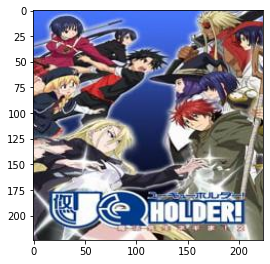

In [24]:
# visualize image
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(full_data[anime_index.index(sample_pick), :, :, :]);

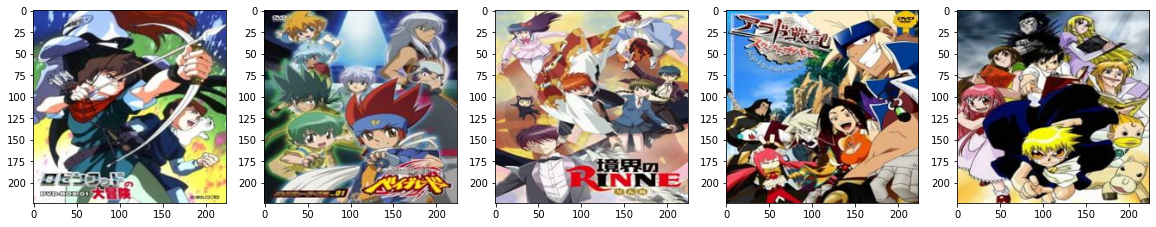

In [25]:
# plot top 5
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,5,1)
ax1.imshow(full_data[sim_score[0][0], :, :, :])
ax2 = fig.add_subplot(1,5,2)
ax2.imshow(full_data[sim_score[1][0], :, :, :])
ax3 = fig.add_subplot(1,5,3)
ax3.imshow(full_data[sim_score[2][0], :, :, :])
ax4 = fig.add_subplot(1,5,4)
ax4.imshow(full_data[sim_score[3][0], :, :, :])
ax5 = fig.add_subplot(1,5,5)
ax5.imshow(full_data[sim_score[4][0], :, :, :]);

**Get the meta data of animes**

In [26]:
meta_data = pd.read_csv(r'processed_data/processed_anime.csv')
meta_data.shape

(4808, 92)

In [27]:
# get reference image data
meta_data[meta_data['index'] == sample_pick][['index', 'Title', 'URL', 'Synonyms', 'Genres', 'Rating', 'Score', 'Ranked', 'Synopsis', 'anime_uid']]

,index,Title,URL,Synonyms,Genres,Rating,Score,Ranked,Synopsis,anime_uid
1734,3625,UQ Holder!: Mahou Sensei Negima! 2,https://myanimelist.net/anime/33478/UQ_Holder_...,"Yuukyuu Holder, Eternal Holder","['Action', 'Sci-Fi', 'Magic', 'Fantasy', 'Shou...",PG-13 - Teens 13 or older,7.01,#3626,Touta Konoe is an ordinary boy raised in a sma...,33478


In [28]:
# get similar anime meta data
sample_names = [anime_index[i[0]] for i in sim_score]

In [29]:
meta_data.set_index('index').loc[sample_names].reset_index()[['index', 'Title', 'URL', 'Synonyms', 'Genres', 'Rating', 'Score', 'Ranked', 'Synopsis', 'anime_uid']]

,index,Title,URL,Synonyms,Genres,Rating,Score,Ranked,Synopsis,anime_uid
0,3105,Robin Hood no Daibouken,https://myanimelist.net/anime/2543/Robin_Hood_...,NaN,"['Adventure', 'Historical', 'Romance']",G - All Ages,7.12,#3106,A variant of Robin Hood in which all the princ...,2543
1,5023,Metal Fight Beyblade,https://myanimelist.net/anime/5962/Metal_Fight...,Beyblade: Metal Fusion,"['Adventure', 'Comedy', 'Sports']",PG - Children,6.68,#5024,A new cast of characters take on the continued...,5962
2,4081,Kyoukai no Rinne (TV),https://myanimelist.net/anime/28423/Kyoukai_no...,NaN,"['Comedy', 'Supernatural', 'Romance', 'School'...",PG-13 - Teens 13 or older,6.89,#4082,A very strange thing happened to Mamiya Sakura...,28423
3,4659,Arad Senki: Slap Up Party,https://myanimelist.net/anime/4657/Arad_Senki_...,"Slap Up Party Arad Senki, Dungeon & Fighter - ...","['Action', 'Adventure', 'Comedy', 'Fantasy']",PG-13 - Teens 13 or older,6.75,#4660,"The anime will follow the adventures of Baron,...",4657
4,1426,Konjiki no Gash Bell!!,https://myanimelist.net/anime/250/Konjiki_no_G...,NaN,"['Adventure', 'Comedy', 'Demons', 'Supernatura...",PG-13 - Teens 13 or older,7.55,#1427,"Takamine Kiyomaro, a depressed don't-care-abou...",250
5,738,InuYasha,https://myanimelist.net/anime/249/InuYasha,Inu Yasha,"['Action', 'Adventure', 'Comedy', 'Historical'...",PG-13 - Teens 13 or older,7.85,#739,Based on the Shogakukan award-winning manga of...,249
6,3074,Kenyuu Densetsu Yaiba,https://myanimelist.net/anime/2335/Kenyuu_Dens...,NaN,"['Action', 'Comedy', 'Fantasy', 'Martial Arts'...",PG-13 - Teens 13 or older,7.13,#3075,Kurogane Yaiba is a boy who doesn't want to be...,2335
7,3088,Senkaiden Houshin Engi,https://myanimelist.net/anime/1108/Senkaiden_H...,"Romances of Sealed Gods, Soul Hunter: Battle o...","['Magic', 'Adventure', 'Fantasy', 'Supernatura...",PG-13 - Teens 13 or older,7.13,#3089,"Thousands of years ago, it was a time of witch...",1108
8,1958,Sengoku Basara,https://myanimelist.net/anime/5355/Sengoku_Basara,NaN,"['Action', 'Historical', 'Martial Arts', 'Samu...",PG-13 - Teens 13 or older,7.39,#1959,"During Japan's Sengoku period, several powerfu...",5355
9,243,Major S1,https://myanimelist.net/anime/627/Major_S1,NaN,"['Comedy', 'Sports', 'Drama', 'Shounen']",PG-13 - Teens 13 or older,8.28,#244,"Gorou Honda, a little boy obsessed with baseba...",627


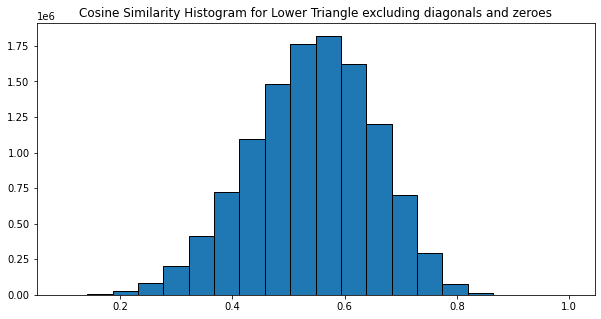

In [30]:
# take lower half of cosine similarity, excluding the diagonals
lower_tri = np.tril(image_cosine, -1)
lower_tri = lower_tri.reshape(-1)

# remove all zeros
lower_tri = lower_tri[lower_tri != 0]

# plot distribution of cosine similarity matrix
fig = plt.figure(figsize=(10,5))
plt.hist(lower_tri, bins=20, ec='black')
plt.title('Cosine Similarity Histogram for Lower Triangle excluding diagonals and zeroes');

## 4. Save the similarity matrix and indices

In [38]:
matrix_index = [i[0] for i in enumerate(anime_index)]

In [39]:
index_names = pd.DataFrame({
    'matrix_index': matrix_index,
    'anime_name_index': anime_index
})

In [40]:
index_names.head()

,matrix_index,anime_name_index
0,0,0
1,1,1
2,2,100
3,3,10007
4,4,10009


In [41]:
# fetch in corresponding anime_uid
index_names = index_names.merge(meta_data[['index', 'anime_uid']], how='left',  left_on='anime_name_index', right_on='index')
index_names.head()

,matrix_index,anime_name_index,index,anime_uid
0,0,0,0,5114
1,1,1,1,40028
2,2,100,100,31933
3,3,10007,10007,32606
4,4,10009,10009,36458


In [42]:
matrix = pd.DataFrame(image_cosine, index=index_names['anime_uid'], columns=index_names['anime_uid'])

In [43]:
matrix.head()

anime_uid,5114,40028,31933,32606,36458,36510,19755,31747,36001,37601,...,35252,33572,23375,28249,34383,2391,30251,3841,40129,32981
anime_uid,,,,,,,,,,,,,,,,,,,,,
5114,1.000000,0.579354,0.483831,0.487176,0.490197,0.527587,0.383979,0.330409,0.512764,0.624554,...,0.574815,0.536580,0.481655,0.663071,0.514402,0.399402,0.524140,0.529654,0.390801,0.503373
40028,0.579354,1.000000,0.543361,0.563768,0.666094,0.664799,0.445946,0.360934,0.497296,0.618467,...,0.644390,0.618317,0.518687,0.674076,0.444296,0.577705,0.654076,0.468878,0.494590,0.521505
31933,0.483831,0.543361,1.000000,0.520416,0.515702,0.516926,0.471599,0.430772,0.523110,0.547255,...,0.605083,0.532426,0.525131,0.520072,0.603503,0.453703,0.571069,0.480519,0.458005,0.701979
32606,0.487176,0.563768,0.520416,1.000000,0.744595,0.621367,0.625932,0.548875,0.739722,0.553243,...,0.655956,0.783569,0.670250,0.552249,0.471447,0.671362,0.739752,0.540741,0.695998,0.503787
36458,0.490197,0.666094,0.515702,0.744595,1.000000,0.763105,0.573874,0.497241,0.636405,0.554914,...,0.620660,0.696791,0.686700,0.642505,0.387363,0.753787,0.772863,0.526165,0.613333,0.471141


In [44]:
# save files
matrix.to_csv(r'processed_data/images_squashed/image_cosine_similarity.csv', header=False, index=False)
index_names.to_csv(r'processed_data/images_squashed/image_index_names.csv', header=True, index=False)
np.save(r'processed_data/images_squashed/resnet50_features.npy', np.array(embedded_vector))

## 6. Calculate Prediction Ratings

With the cosine similarity score, we can calculate the predicted rating for every user.  
The steps to do so are summarised below:  
1. Split reviews data into train and test data  
2. For every user in the train dataset, we identify the animes which have been watched by the user and animes which have not been watched by the user. We used rating as a proxy of whether user had watched the anime. 
3. Thereafter, we compute the predicted rating for Item i for User by applying the formula:  
$\hat{P}_{u,i} = \frac {\sum \limits _{m \in I} (r_{u,m} * s_{i,m})} {\sum \limits _{m \in I} s_{i,m}}  $  
4. Based on the predicted ratings, we identify Top 10 items to be recommended to user and compute the hit rate by comparing it against the test dataset.


**import dataset**

In [49]:
df_review = pd.read_csv('processed_data/processed_reviews.csv')
df_review.shape

(75921, 7)

In [51]:
# subset reviews for animes within scope
df_review = df_review[df_review['anime_uid'].isin(index_names['anime_uid'].tolist())]
print(len(df_review))

75921


In [52]:
df_review.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

In [53]:
# check the distribution of ratings
df_review['score'].describe()

count    75921.000000
mean         7.353038
std          2.219829
min          0.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: score, dtype: float64

**a. Train Test Split**

Apply the leave-one-out methodology to do train-test split. For each user, the most recent review is used as the test set. The most recent review is indicated by the larger uid. The reamining ratings would be used in the train dataset. This will help to ensure no data leakage.

In [54]:
# create test dataset
test = df_review.loc[df_review.groupby('profile')['uid'].idxmax()]
test.shape

(15363, 7)

In [55]:
# create train dataset
train = df_review[~(df_review['uid'].isin(test['uid'].tolist()))]
train.shape

(60558, 7)

**b. Identify animes which have been watched by users as well as those which have not been watched by users**

In [56]:
# create a unique list of anime_uid
anime_uid = list(set(index_names['anime_uid'].tolist()))
len(anime_uid)

4801

In [57]:
# create a unique list of profiles from train dataset
profile_list = list(set(train['profile'].tolist()))
len(profile_list)

15363

In [58]:
# identify list of animes watched 
# identify the list of animes not watched. As the not watched list is huge, 
# we randomly sample 99 animes not watched items + the one watched item in the test data to form the not watched list.
# we repeat this random sampling 10 times to ensure robustness while accounting for limited computational resource.

watched_list = []
not_watched_list_1 = []
not_watched_list_2 = []
not_watched_list_3 = []
not_watched_list_4 = []
not_watched_list_5 = []

for user in profile_list:
    
    # subset watched animes - i.e. those with ratings
    u_watched = train[train['profile']==user]['anime_uid'].tolist()
    watched_list.append(u_watched)
    
    # identify animes not watched i.e. those without ratings
    u_not_watched = list(set(anime_uid) - set(u_watched) - set(test[test['profile']==user]['anime_uid'].tolist()))
    
    # set seed to control reproducibility of sampling
    random.seed(2345)
    u_not_watched_1 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_1.append(u_not_watched_1)
    
    random.seed(2346)
    u_not_watched_2 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_2.append(u_not_watched_2)
    
    random.seed(2347)
    u_not_watched_3 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_3.append(u_not_watched_3)
    
    random.seed(2348)
    u_not_watched_4 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_4.append(u_not_watched_4)
    
    random.seed(2349)
    u_not_watched_5 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_5.append(u_not_watched_5)


In [59]:
# check len of watched_list and not watched list
print(len(watched_list))
print(len(not_watched_list_1))
print(len(not_watched_list_5))

15363
15363
15363


In [60]:
# check 
print(len(watched_list[0]))
print(len(not_watched_list_1[0]))
print(len(not_watched_list_5[0]))

5
100
100


**c. Compute the predicted ratings for not watched list for each user**

In [61]:
# Create a function to compute the predicted ratings for not watched list for each user

def predict_ratings(profile, not_watched, train_dataset, sim_matrix):
    
    '''
    Args:
        profile - list of unique profiles
        not_watched - list of not watched animes for all users
        train_dataset - train data
        sim_matrix - matrix capturing the cosine similarity between every pair of anime x and anime y
    
    Returns:
        predicted_ratings - nested list of predicted ratings for each user

    '''
    
    # initialise list to store predictions
    predicted_rating = []
    
    for i in range(len(profile)):
        
        # subset the ratings for watched animes
        watched_animes_ratings = train_dataset[train_dataset['profile']==profile[i]][['score', 'anime_uid']].sort_values(by=['anime_uid'])
    
        # initialise list to store ratings for user
        individual_ratings = []
    
        # subset animes not watched for user
        animes = not_watched[i]
        #print(len(animes))
    
        # iterate through every anime not watched
        for k in animes:          
            
            # subset the cosine similarity vector between anime and watched animes
            cos_sim_subset = sim_matrix[k]
            cos_sim_subset = cos_sim_subset[(cos_sim_subset.index.isin(animes)) | 
                                             (cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist()))]
            total_sim_score = sum(cos_sim_subset)
            cos_sim_subset = cos_sim_subset[cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist())]
            cos_sim_subset = cos_sim_subset.sort_index(ascending=False)
        
            # compute predicted ratings
            for x, y in zip(cos_sim_subset, watched_animes_ratings['score']):
                predictions = np.sum(np.dot(x,y))/total_sim_score
            
            individual_ratings.append(predictions)
    
        #print(len(individual_ratings))
        predicted_rating.append(individual_ratings)
    
    return predicted_rating


In [63]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings_1 = predict_ratings(profile_list, not_watched_list_1, train, matrix)
print('done')
predicted_ratings_2 = predict_ratings(profile_list, not_watched_list_2, train, matrix)
print('done')
predicted_ratings_3 = predict_ratings(profile_list, not_watched_list_3, train, matrix)
print('done')
predicted_ratings_4 = predict_ratings(profile_list, not_watched_list_4, train, matrix)
print('done')
predicted_ratings_5 = predict_ratings(profile_list, not_watched_list_5, train, matrix)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 3961.4712955


**d. Evaluate Hit Rate @ 10 for Proposed Recommender**

In [64]:
# create function to evaluate hit rate @ 10

def hit_rate(predictions, not_watched, test_dataset, profile):
    
    '''
    Args:
        predictions - nested list of predicted ratings of every user for the 100 animes randomly sampled
        not_watched - nested list of 100 animes not watched for each user
        test_dataset - test data
        profile - list of unique profiles
    
    Returns:
        hit_rate - hit rate @ 10
        top_10_animes - nested list of top 10 ainmes recommended for each user 
    '''
    
    top_10_animes = []
    hit = 0
    
    for i in range(len(predictions)):
    
        user = profile[i]
    
        # get the top 10 animes recommended to user
        top_10_idx = np.argsort(predictions[i])[-10:]
        top_10_animes = [not_watched[i][k] for k in top_10_idx]
    
        # check if the test data is found in the proposed top 10 recommended animes
        anime_watched = test_dataset[test_dataset['profile']==user]['anime_uid']

        if anime_watched.values in top_10_animes:
            hit += 1
        else:
            hit = hit
    
    hit_rate = round((hit/len(profile))*100,2)
    
    return top_10_animes, hit_rate

In [65]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes_1, hit_rate_1 = hit_rate(predicted_ratings_1, not_watched_list_1, test, profile_list)
top_10_animes_2, hit_rate_2 = hit_rate(predicted_ratings_2, not_watched_list_2, test, profile_list)
top_10_animes_3, hit_rate_3 = hit_rate(predicted_ratings_3, not_watched_list_3, test, profile_list)
top_10_animes_4, hit_rate_4 = hit_rate(predicted_ratings_4, not_watched_list_4, test, profile_list)
top_10_animes_5, hit_rate_5 = hit_rate(predicted_ratings_5, not_watched_list_5, test, profile_list)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 91.51693750000004


In [66]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate_5))


Hit Rate @ 10 based on not_watched_list_1: 19.45%
Hit Rate @ 10 based on not_watched_list_2: 18.39%
Hit Rate @ 10 based on not_watched_list_3: 19.97%
Hit Rate @ 10 based on not_watched_list_4: 18.85%
Hit Rate @ 10 based on not_watched_list_5: 20.92%


In [67]:
# print avg hit rates
avg_hit_rate = (hit_rate_1 + hit_rate_2 + hit_rate_3 + hit_rate_4 + hit_rate_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: {}%'.format(avg_hit_rate))


Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: 19.516%


In [68]:
# save the results
hit_rates_all = [hit_rate_1, hit_rate_2, hit_rate_3, hit_rate_4, hit_rate_5, avg_hit_rate]

with open("processed_data/images_squashed/model2_results.txt", "wb") as fp:   
    pickle.dump((predicted_ratings_1, predicted_ratings_2, predicted_ratings_3, predicted_ratings_4, predicted_ratings_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes_1, top_10_animes_2, top_10_animes_3, top_10_animes_4, top_10_animes_5, hit_rates_all, \
                watched_list, profile_list), fp)
